In [121]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import wandb
from torch.utils.data import Dataset
import gzip

import glob
from glob import glob
import nibabel as nb
import imageio

from dataclasses import dataclass
from ResnetGenerator import ResnetGenerator
from NLayerDiscriminator import NLayerDiscriminator

class mriDataset(Dataset):
    def __init__(self, input_dir):
        self.mri_files = glob(input_dir+'/*/m*')
    
    def __getitem__(self, idx):
        print(idx)
        vol = round(idx/80)
        mri_vol = gzip.GzipFile(self.mri_files[vol],'r');
        
        slice = idx-vol*80;
        mri_img = np.load(mri_vol)[:,:,150+slice:150+slice+4]

        return torch.from_numpy(mri_img)

class sosDataset(Dataset):
    def __init__(self, input_dir):
        self.sos_files = glob(input_dir+'/*/V*')
    
    def __getitem__(self, idx):
        vol = round(idx/80)
        sos_vol = gzip.GzipFile(self.sos_files[vol],'r');
        
        slice = idx-vol*80;
        sos_img = np.load(sos_vol)[:,:,150+slice:150+slice+4]

        return torch.from_numpy(sos_img)


def init_dataset(bs, test=False):
    if(test == False): path = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/train';
    if(test == True): path = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/test';
    dataloader_mri = mriDataset(path);
    dataloader_sos = sosDataset(path);
    
    return dataloader_mri, dataloader_sos    

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [122]:
dataloader_mri, dataloader_sos = init_dataset(1, False)
iter_mri = iter(dataloader_mri)
a = next(iter_mri);
a=torch.permute(a,(2,0,1));
a.shape

iter_sos = iter(dataloader_sos)
a = next(iter_sos);

0


In [116]:
mri_files = glob('../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/train'+'/*/m*');

In [118]:

vol = round(1/80)
mri_vol = gzip.GzipFile(mri_files[vol],'r');

slice = 1-vol*80;
mri_img = torch.from_numpy(np.load(mri_vol)[:,:,150+slice:150+slice+4])     # get slice from volume

# transforms
mri_img = mri_img/torch.max(mri_img).item()                     # normalize

In [120]:
mri_img = mri_img + (0.001**0.5)*torch.randn(256,320,4)           # add noise

In [87]:
from ResnetGenerator3D import ResnetGenerator3D
m = ResnetGenerator3D(input_nc=1,output_nc=1,ngf=12,norm_layer=nn.BatchNorm3d, use_dropout=False, n_blocks=2, n_downsampling=2, padding_type='reflect')
b = m(a.unsqueeze(0).unsqueeze(0));
b.shape


torch.Size([1, 1, 4, 256, 320])

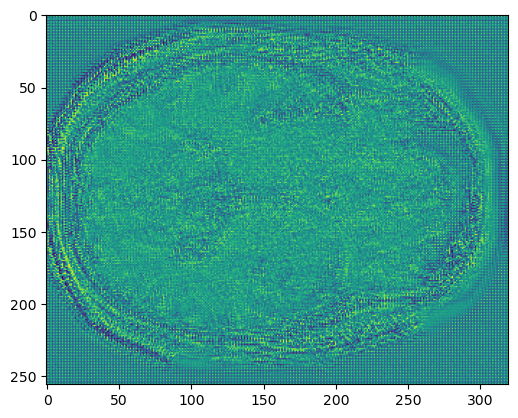

In [35]:
plt.imshow(b[0,0,2,:,:].detach().numpy())

In [55]:
from NLayerDiscriminator3D import NLayerDiscriminator3D
d = NLayerDiscriminator3D(input_nc=1,ndf=64,n_layers=2, norm_layer=nn.BatchNorm3d)

In [43]:
c = d(a.unsqueeze(0).unsqueeze(0))
c.shape

torch.Size([1, 1, 1, 64, 80])

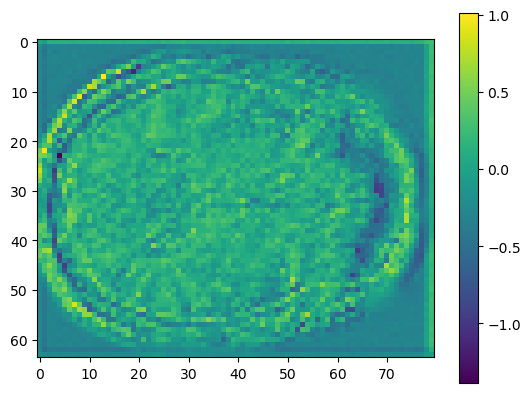

In [48]:
plt.imshow(c[0,0,0,:,:].detach().numpy()); plt.colorbar()

In [49]:
@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int
    lr : float
    beta1 : float

p = Parameters(bs=1, n_channels=1, ngf=128, ndf=16, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=2, lr=0.0002, beta1=0.5)

In [106]:
G_A2B = ResnetGenerator3D(input_nc=1,output_nc=1,ngf=12,norm_layer=nn.BatchNorm3d, use_dropout=False, n_blocks=2, n_downsampling=2, padding_type='reflect')
G_B2A = ResnetGenerator3D(input_nc=1,output_nc=1,ngf=12,norm_layer=nn.BatchNorm3d, use_dropout=False, n_blocks=2, n_downsampling=2, padding_type='reflect')
D_A = NLayerDiscriminator3D(input_nc=1,ndf=64,n_layers=2, norm_layer=nn.BatchNorm3d)
D_B = NLayerDiscriminator3D(input_nc=1,ndf=64,n_layers=2, norm_layer=nn.BatchNorm3d)

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))


In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)

NLayerDiscriminator3D(
  (model): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (6): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv3d(256, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
)

In [108]:
def train(epochs, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B, dataloader_mri, dataloader_sos, old=True):

  print(wandb.config)  

  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(epochs):
    print('Epoch: ', str(epoch))

    # For each batch in the d0ataloader
    for i in range(1,2000): #enumerate(zip(dataloader_mri, dataloader_sos),0):
        # Set model input
        a_real = next(iter_mri)
        a_real = torch.permute(a_real,(2,0,1));
        a_real = a_real.unsqueeze(0).unsqueeze(0).float().to(device)
        b_real = next(iter_sos)
        b_real = torch.permute(b_real,(2,0,1));
        b_real = b_real.unsqueeze(0).unsqueeze(0).float().to(device)
      
        # Generate images
        b_fake = G_A2B(a_real)
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)

        # CALCULATE DISCRIMINATORS LOSSES
        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(1, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())

        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B
        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(1, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator
        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # CALCULATE GENERATORS LOSSES
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses
        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        wandb.log({
            "disc_loss_A2B": Fool_disc_loss_A2B,
            "disc_loss_B2A": Fool_disc_loss_B2A,
            "Cycle_loss_A": Cycle_loss_A,
            "Cycle_loss_B": Cycle_loss_B,
            "id_loss_A2B": Id_loss_A2B,
            "id_loss_B2A": Id_loss_B2A,
            "total_g": Loss_G,
            "total_d": Fool_disc_loss_A2B + Fool_disc_loss_B2A
        })

        # Backward propagation
        Loss_G.backward()
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == p.bs*5 and b_fake.shape[0]==p.bs):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        #   print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
        #               % (epoch+1, epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)
#   return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,disc_A_t,disc_B_t)


In [109]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))
def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)
criterion_Im = torch.nn.L1Loss()

In [110]:
wandb.login()
name = '230328'
wandb.init(project='2023-mri2sos', entity='clara_rg_')

train(10, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B, iter_mri, iter_sos)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


{}
Starting Training Loop...
Epoch:  0
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
[1/10]	FDL_A2B: 0.7867	FDL_B2A: 0.4015	CL_A: 2655.2366	CL_B: 8305.5742	ID_B2A: 5310.4707	ID_A2B: 16611.1250	Loss_D_A: 0.3214	Loss_D_A: 0.0719
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
[1/10]	FDL_A2B: 0.8830	FDL_B2A: 0.7185	CL_A: 2773.4702	CL_B: 8218.6133	ID_B2A: 5546.9380	ID_A2B: 16436.8555	Loss_D_A: 0.0393	Loss_D_A: 0.0232
107
108
109
110
111
112
113
114
115
116
117


KeyboardInterrupt: 

In [102]:

a_real = next(iter_mri)
a_real = torch.permute(a_real,(2,0,1));
a_real = a_real.unsqueeze(0).unsqueeze(0).float().to(device)

6


In [90]:
ResnetGenerator3D(input_nc=1,output_nc=1,ngf=12,norm_layer=nn.BatchNorm3d, use_dropout=False, n_blocks=2, n_downsampling=2, padding_type='reflect')(a.unsqueeze(0).unsqueeze(0))

tensor([[[[[-5.0931e-01, -1.2539e-01, -4.1625e-01,  ...,  1.9894e-01,
            -1.5151e-01,  3.3555e-01],
           [ 8.6299e-02, -3.0307e-01,  3.4786e-01,  ..., -2.0618e-01,
            -5.0788e-04, -4.2561e-01],
           [-3.3879e-01, -2.7741e-01, -1.3380e-01,  ..., -3.1507e-01,
            -2.5232e-01, -1.3878e-01],
           ...,
           [ 5.5366e-02, -1.0435e-01,  3.0236e-01,  ..., -1.9084e-01,
             8.5552e-02, -2.2137e-01],
           [-6.2443e-01, -4.7287e-01, -4.8477e-01,  ..., -4.7128e-01,
            -5.9986e-01, -3.6680e-01],
           [-1.5406e-01, -2.0489e-01,  1.3003e-01,  ..., -2.7550e-01,
            -2.3029e-01, -3.5572e-01]],

          [[ 2.0971e-01, -6.1350e-02, -4.6428e-01,  ...,  3.2226e-01,
            -9.3998e-02,  2.1085e-01],
           [-3.8744e-01, -6.3601e-01,  6.6442e-02,  ..., -1.5487e-01,
            -4.9056e-01, -3.5747e-02],
           [-7.8737e-02, -2.8102e-01, -5.3740e-01,  ..., -3.8946e-02,
            -2.9866e-01, -1.4680e-01],
 